In [89]:
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import HDBSCAN
from sklearn.cluster import DBSCAN
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import umap.plot
# from sklearn.manifold import TSNE
%matplotlib inline

RHO_CUTOFF = 0.4

plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = [16,16]



In [90]:

path = '../data/processed/pca_inputs/MQT_pip.csv'
features = ['std_Log10_n0', 'std_Log10_lambda', 'std_Fs', 'std_Rho', 'std_D0', 'std_Nt']#, 'std_Sr', 'std_Ed']


df_all = pd.read_csv(path)
df_all.dropna(inplace=True)
df_all = df_all[df_all['Rho'] <= RHO_CUTOFF]
print(df_all)

scaled_data = df_all.loc[:, features].values
print(scaled_data)

                    time        D0         Nt        Fs       Sr      Ed  \
0        2015-01-31 2:25  1.132814    720.427  0.032079  0.00040  0.0172   
1        2015-01-31 2:30  1.281362    697.520  0.036792  0.00100  0.0252   
2        2015-01-31 2:35  1.190393   1764.648  0.046121  0.00200  0.0314   
3        2015-01-31 2:40  1.296959   2757.418  0.061816  0.00620  0.0386   
4        2015-01-31 2:45  1.076994   1267.181  0.032342  0.00100  0.0286   
...                  ...       ...        ...       ...      ...     ...   
102982  2022-11-16 23:15  1.241243  21848.593  0.103993  0.14544  0.1498   
102983  2022-11-16 23:20  1.177725  24338.703  0.095635  0.10484  0.1528   
102984  2022-11-16 23:25  1.199251  22246.571  0.104299  0.04398  0.1374   
102985  2022-11-16 23:30  1.172974  21796.181  0.099329  0.00874  0.1144   
102986  2022-11-16 23:35  1.006514  22899.280  0.086099  0.00266  0.1258   

             Rho  Log10_n0  Log10_lambda  std_Log10_n0  std_Log10_lambda  \
0       0.0

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

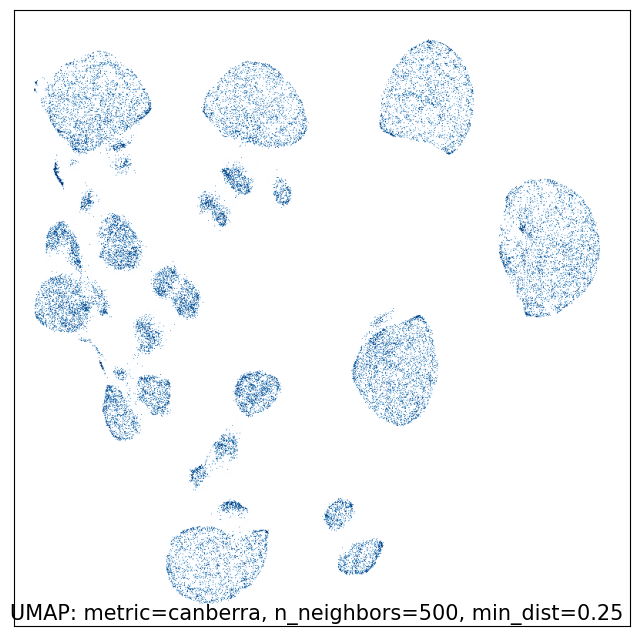

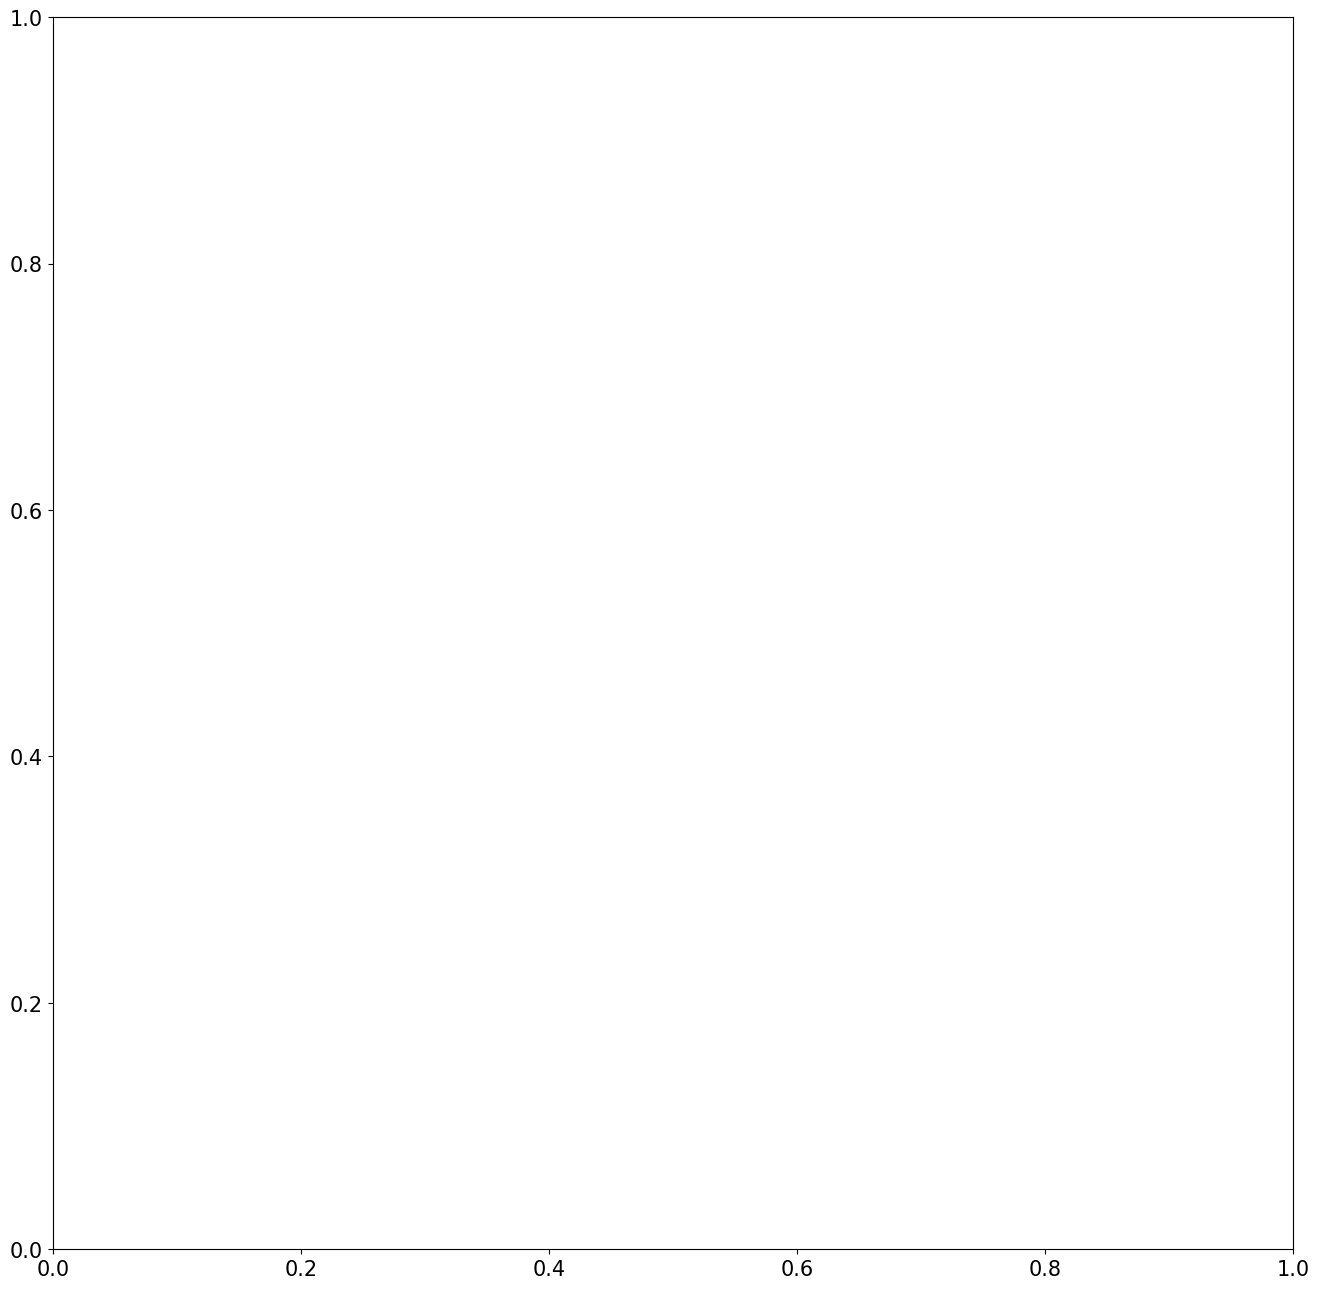

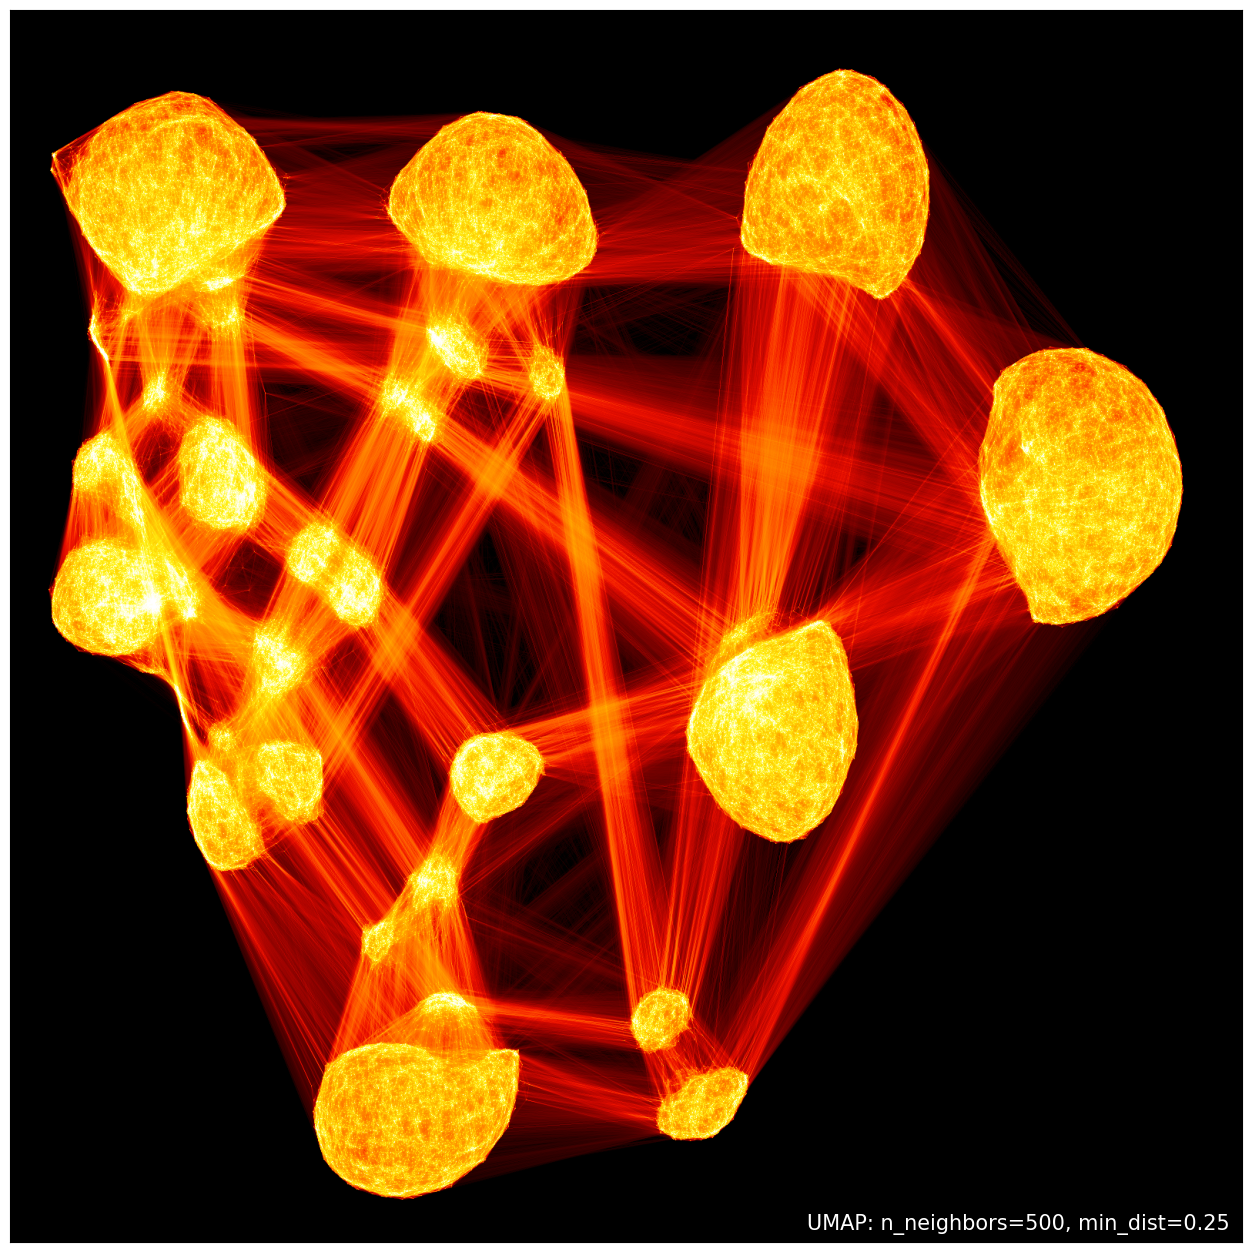

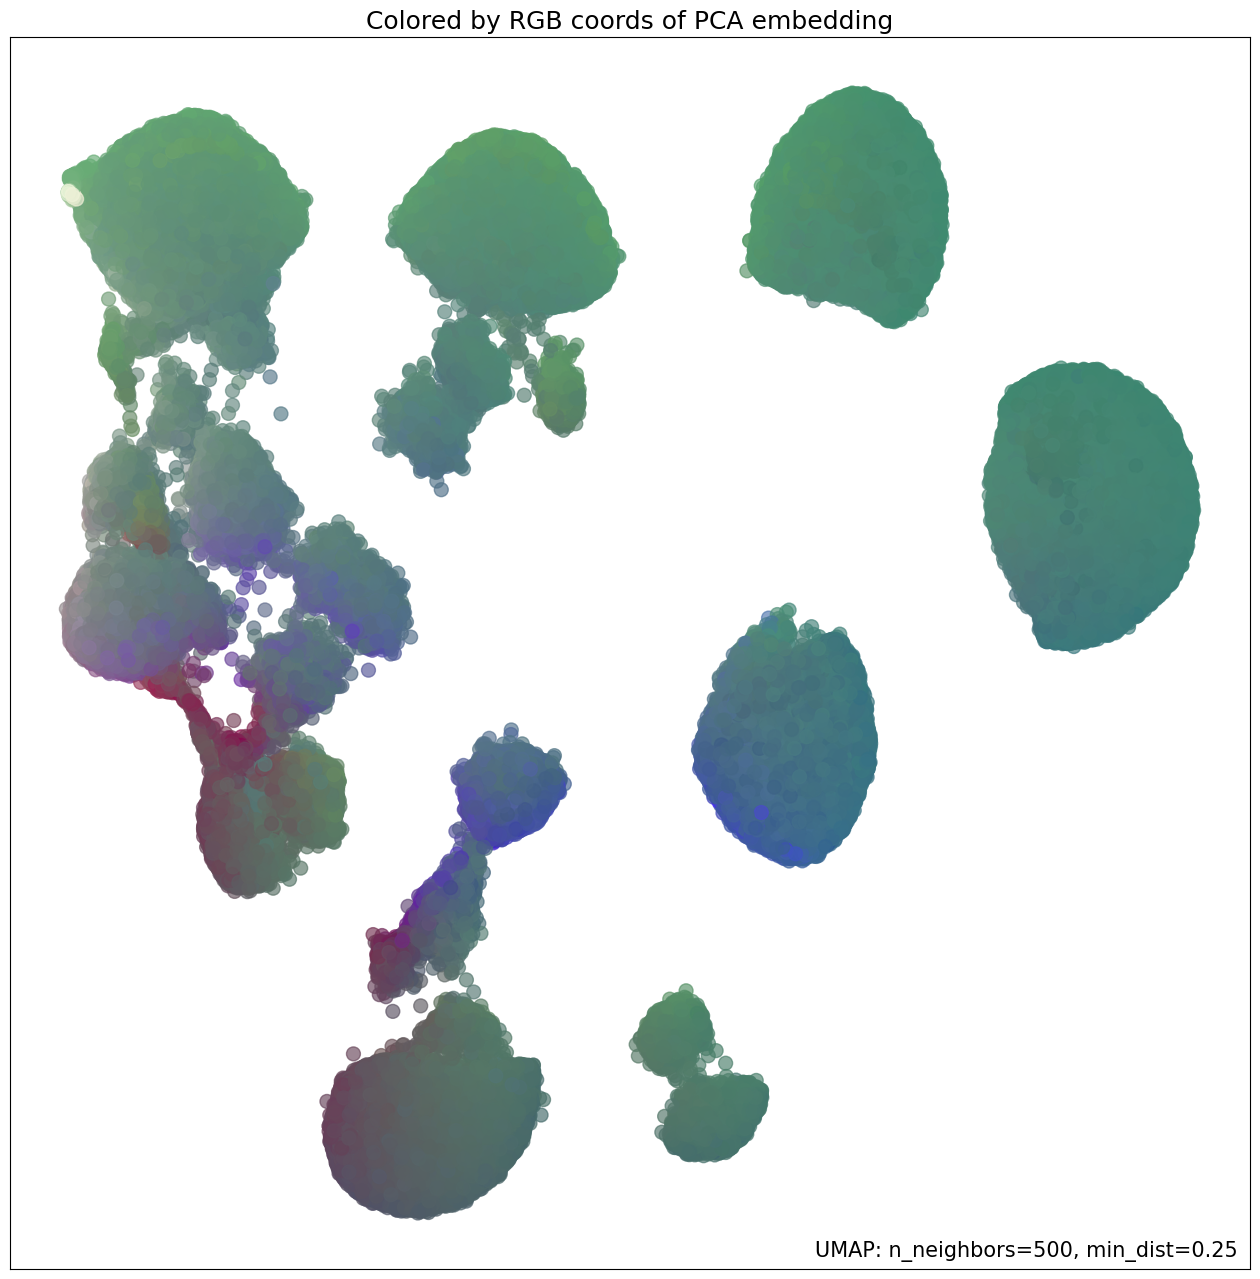

In [91]:

reducer = umap.UMAP(n_neighbors=500, min_dist=0.2, metric='canberra')
embedding = reducer.fit_transform(scaled_data)

mapper = umap.UMAP(n_neighbors=500, min_dist=0.25, metric='canberra').fit(scaled_data)
umap.plot.points(mapper)

fig, ax = plt.subplots(1, figsize=(16, 16))
umap.plot.connectivity(mapper, theme='fire', width=1600, height=1600)

fig, ax = plt.subplots(1, figsize=(16, 16))
umap.plot.diagnostic(mapper, diagnostic_type='pca', point_size=100, ax=ax)



In [97]:

df = pd.DataFrame(data={'eof1': embedding[:, 0], 'eof2': embedding[:, 1]})
scan = HDBSCAN(min_cluster_size=30, cluster_selection_epsilon=0.8).fit(df)


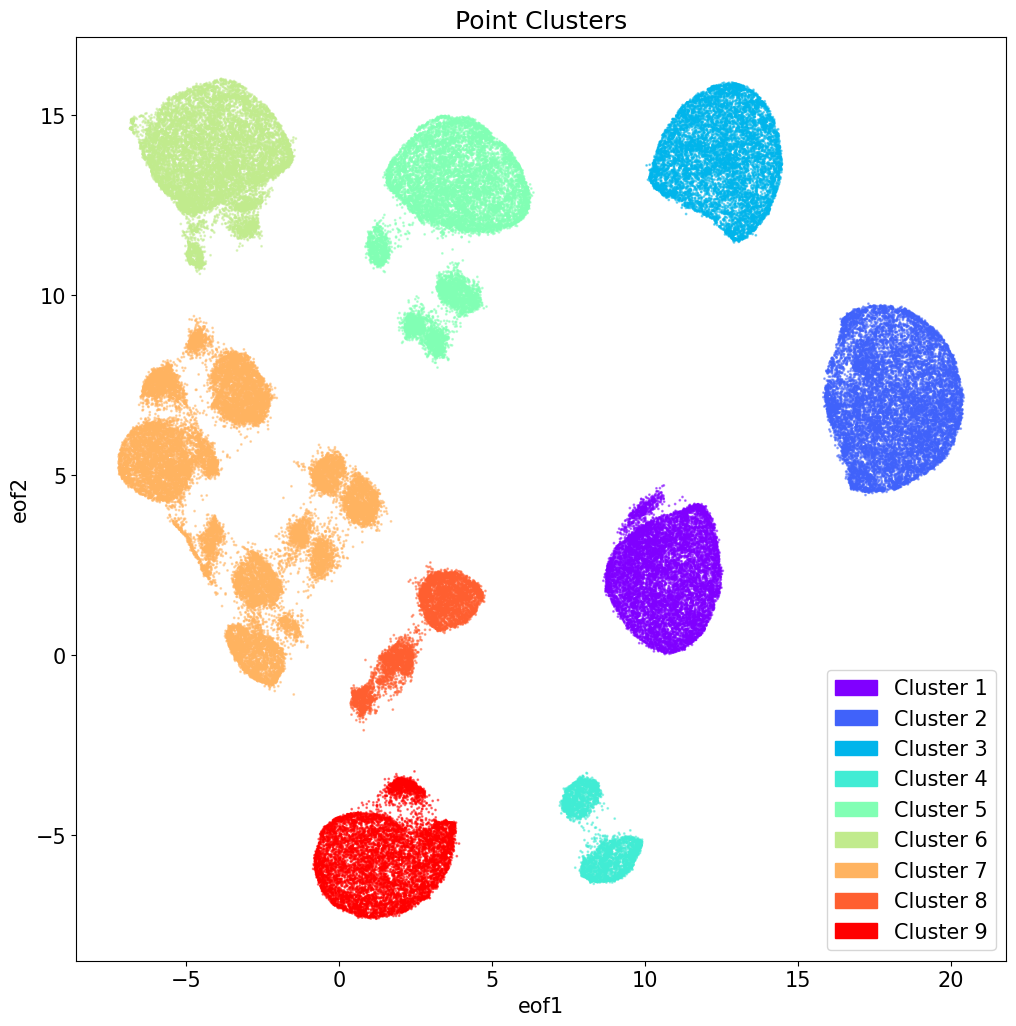

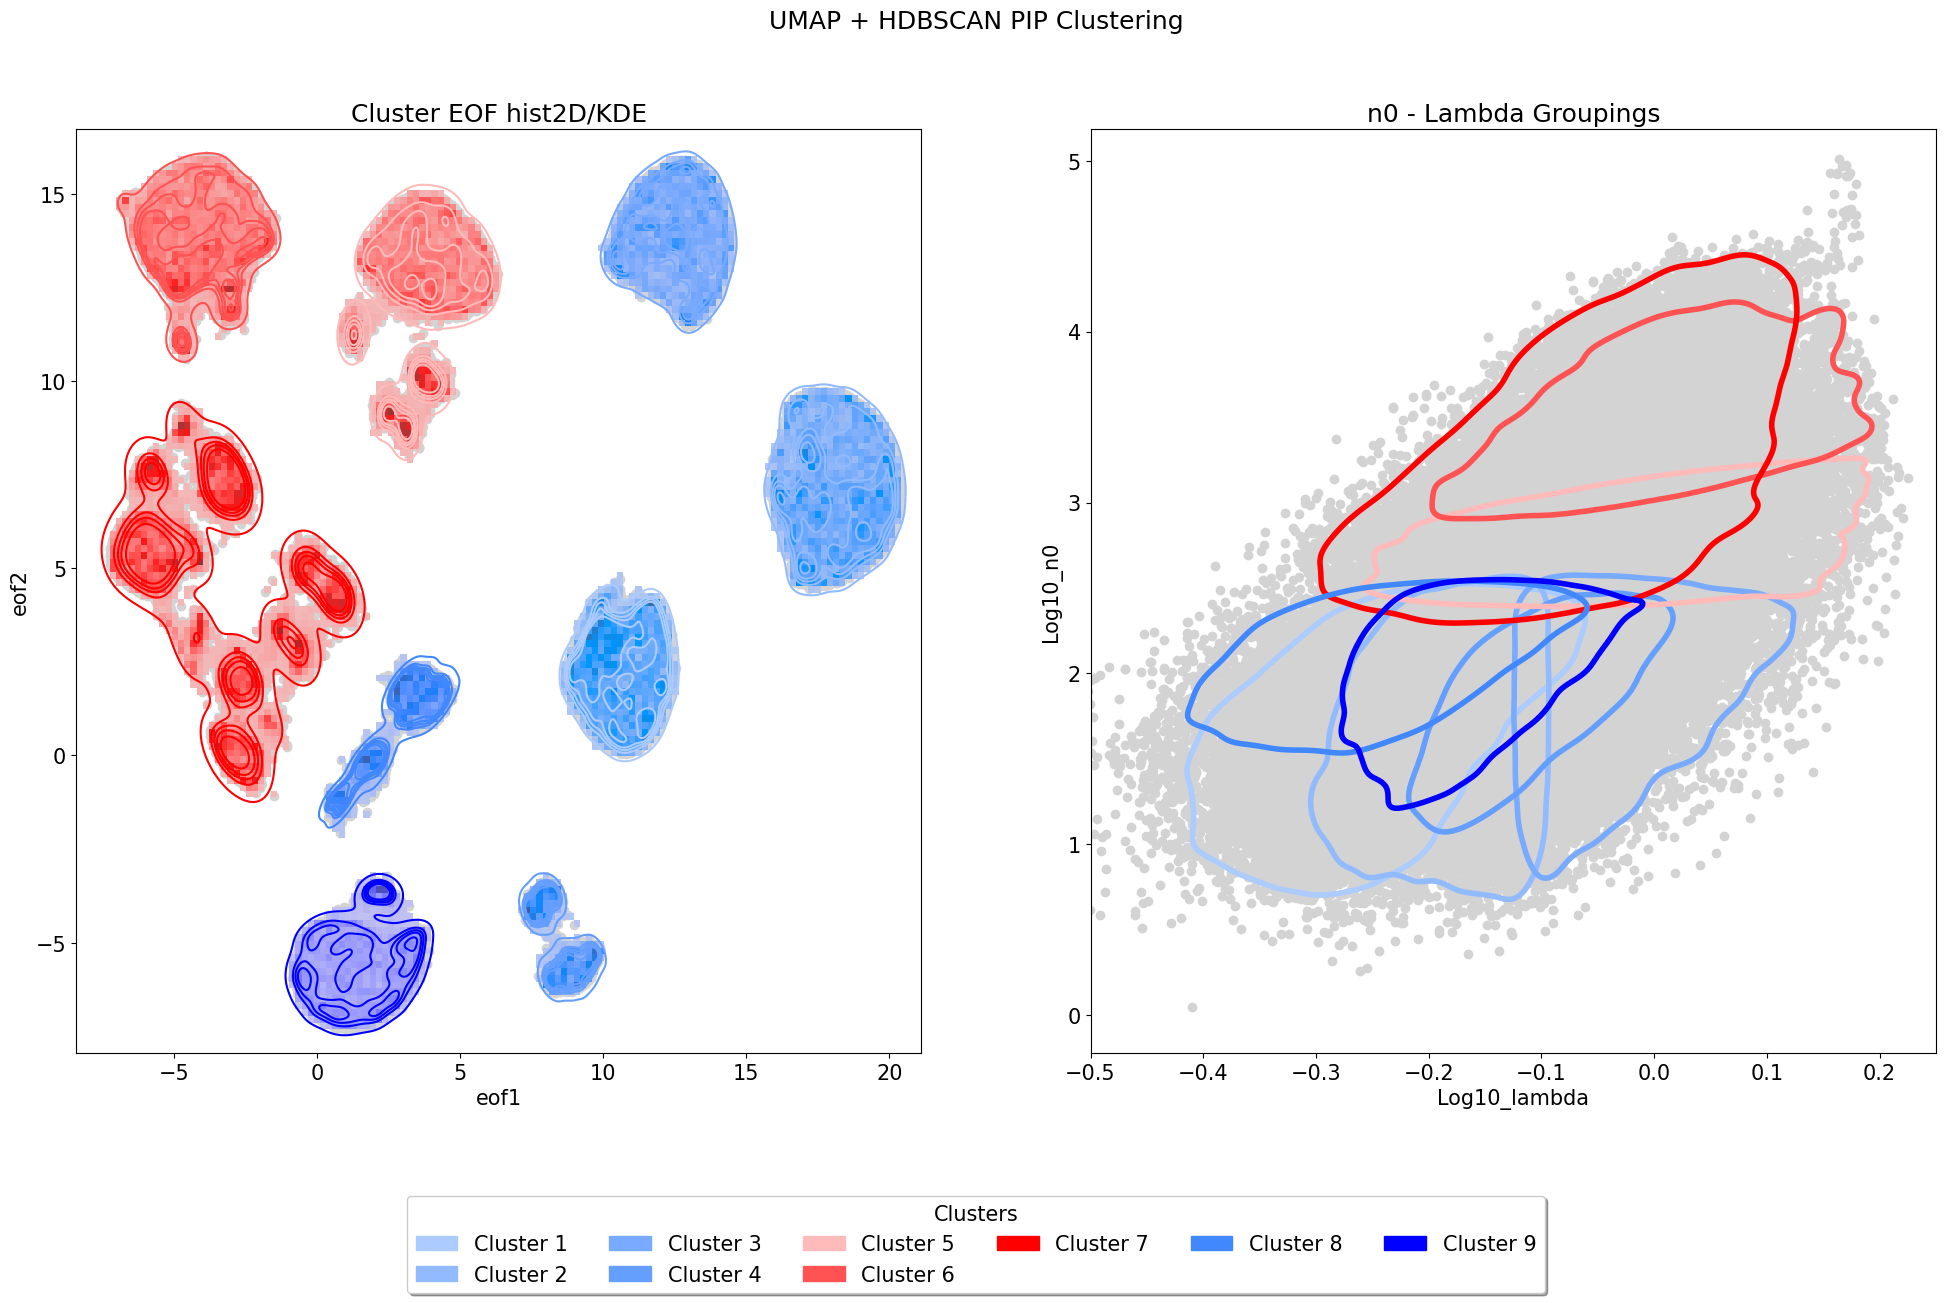

In [100]:

df['new_cluster'] = scan.labels_ + 1
unique_clusters = np.unique(df['new_cluster'])
df_all['cluster_db'] = df['new_cluster'].values



#### Plot 1

colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_clusters)))
cluster_colors = {cluster: color for cluster, color in zip(unique_clusters, colors)}
point_colors = [cluster_colors[cluster] for cluster in df['new_cluster']]

fig, ax = plt.subplots(figsize=(12,12))
plt.title("Point Clusters")
plt.ylabel("eof2")
plt.xlabel("eof1")

plt.scatter(embedding[:, 0], embedding[:, 1], s=1, color=point_colors, alpha=0.5)
legend_elements = [mpatches.Patch(color=color, label=('ambiguous' if cluster == 0 else f'Cluster {cluster}'))
                   for cluster, color in cluster_colors.items()]
ax.legend(handles=legend_elements)
plt.show()



#### Plot 2

###colors = plt.cm.bwr(np.linspace(0, 1, len(unique_clusters)))
colors = ['#accbff', '#92bbff', '#78aaff', '#649eff', '#ffbaba', '#ff5252', '#ff0000', '#4188ff', '#0000ff']

cluster_colors = {cluster: color for cluster, color in zip(unique_clusters, colors)}
patches = []  # Will hold the custom patches for the legend

fig, axs = plt.subplots(1, 2, figsize=(24, 12))  # 1 row, 2 columns
fig.suptitle("UMAP + HDBSCAN PIP Clustering")
axs[0].set_title("Cluster EOF hist2D/KDE")

# First subplot
axs[0].scatter(df['eof1'], df['eof2'], color='lightgray')
axs[1].scatter(df_all[df_all['cluster_db'] == 0]['Log10_lambda'], df_all[df_all['cluster_db'] == 0]['Log10_n0'], color='black')
sns.histplot(data=df[df['new_cluster'] != 0], x='eof1', y='eof2', hue='new_cluster', palette=cluster_colors, bins=128, legend=False, cbar=False, ax=axs[0])
sns.kdeplot(data=df[df['new_cluster'] != 0], x='eof1', y='eof2', hue='new_cluster', palette=cluster_colors, levels=6, legend=False, cbar=False, ax=axs[0])
for cluster, color in zip(unique_clusters, colors):
    if cluster != 0:  # Don't create patch for 'Noise points'
        patches.append(mpatches.Patch(color=color, label=f'Cluster {cluster}'))

# Second subplot
axs[1].set_xlim((-0.5, 0.25))
axs[1].set_title("n0 - Lambda Groupings")

# Plot all points in light gray for subplot 2
axs[1].scatter(df_all['Log10_lambda'], df_all['Log10_n0'], color='lightgray')

sns.kdeplot(data=df_all, x="Log10_lambda", y="Log10_n0", levels=2, hue="cluster_db", palette=cluster_colors, ax=axs[1], legend=False)
sns.kdeplot(data=df_all, x="Log10_lambda", y="Log10_n0", levels=2, hue="cluster_db", palette=cluster_colors, ax=axs[1], legend=False, fill=False, linewidths=4)  # Additional kdeplot with lines

# Common legend for the two subplots
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0), handles=patches, title='Clusters', fancybox=True, shadow=True, ncol=6)

plt.show()
